In [159]:
import numpy as np
import matplotlib.pyplot as plt
from src.micrograd.lib import Value, Layer, Neuron, MLP

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [160]:
def f(x):
    return 3 * x**2 - 4 * x + 5

In [161]:
f(3.0)

20.0

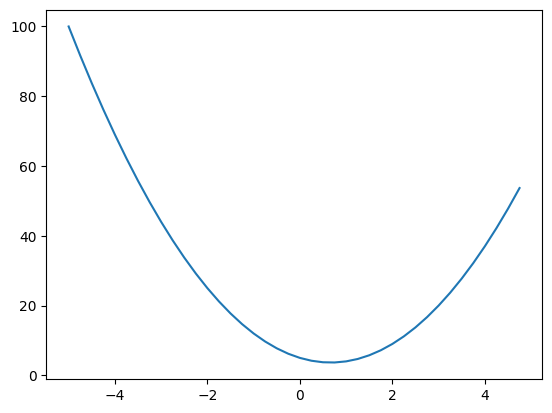

In [162]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [163]:
h = 0.001
x = 3.0
print(f"fx = {f(x)}, f(x+h) = {f(x+h)}", f"f'(x) = {(f(x+h) - f(x))/h}")

fx = 20.0, f(x+h) = 20.014003000000002 f'(x) = 14.00300000000243


Getting more complex

In [164]:
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
print(f"d = {d}")

d = 4.0


In [165]:
h = 0.0001
# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
c += h
d2 = a * b + c

print(f"d1 = {d1}\nd2 = {d2}\nslope={(d2-d1)/h}")

d1 = 4.0
d2 = 4.0001
slope=0.9999999999976694


In [166]:
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
e = a * b
e.label = "e"
d = e + c
d.label = "d"
f = Value(-2.0, label="f")
L = d * f
L.label = "L"

Graphic Viz

In [167]:
from graphviz import Digraph


# make graph representation
def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges

In [168]:
def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})  # LR -> Left to Right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular 'record' node for it
        dot.node(
            name=uid,
            label=f"{n.label} | data {n.data:.4f} | grad {n.grad:.4f}",
            shape="record",
        )
        if n._op:
            # if this is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to id
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

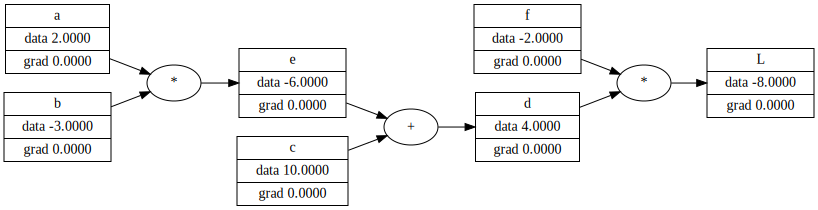

In [169]:
draw_dot(L)

Inputs in Neural Network

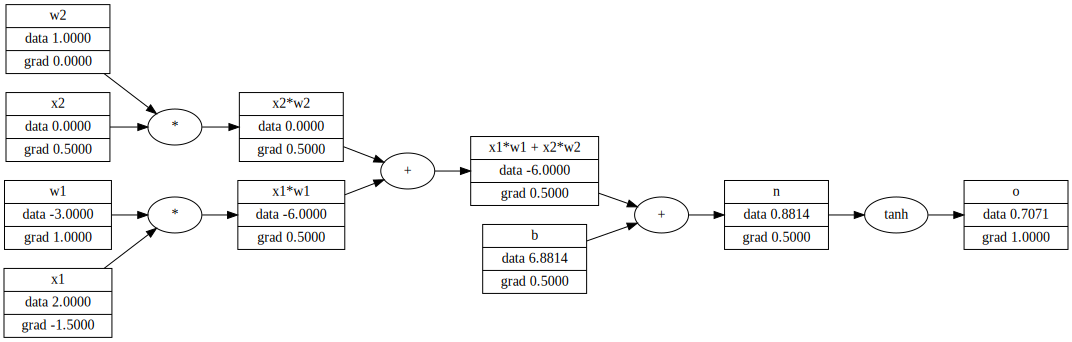

In [170]:
# inputs x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# weights w1, w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# bias of the neuron
b = Value(6.8813735870195432, label="b")

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1
x1w1.label = "x1*w1"
x2w2 = x2 * w2
x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1*w1 + x2*w2"

n = x1w1x2w2 + b
n.label = "n"

o = n.tanh()
o.label = "o"
# ---

o.backward()
draw_dot(o)

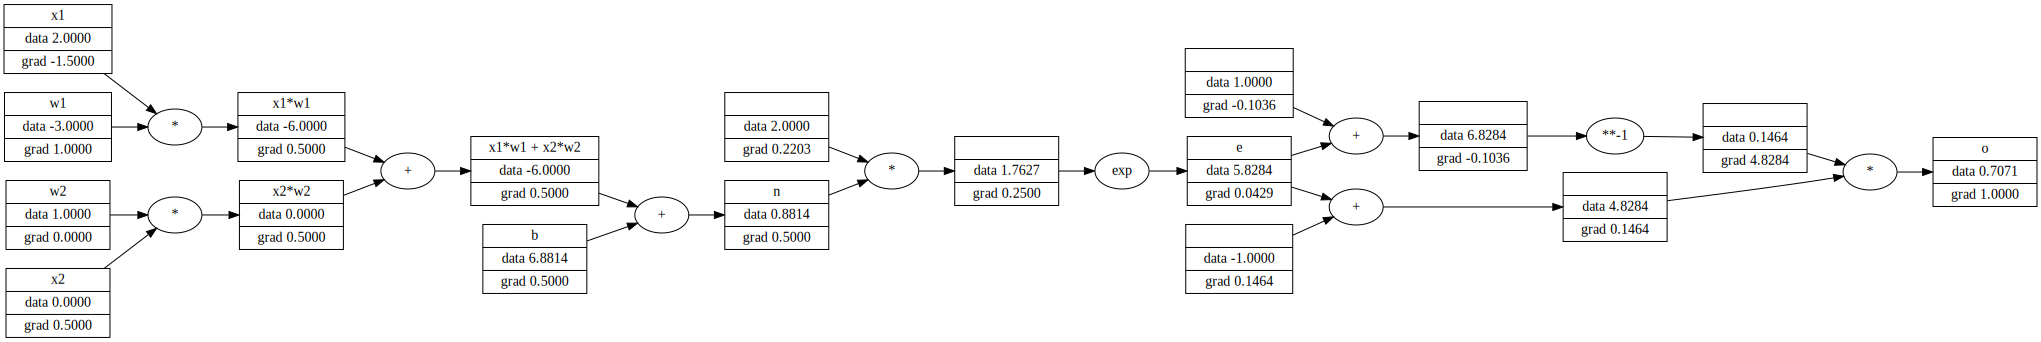

In [171]:
# Same thing but using the atomic operations of `tanh(x)`
# inputs x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# weights w1, w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# bias of the neuron
b = Value(6.8813735870195432, label="b")

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1
x1w1.label = "x1*w1"
x2w2 = x2 * w2
x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1*w1 + x2*w2"

n = x1w1x2w2 + b
n.label = "n"
# ---
e = (2 * n).exp()
e.label = "e"
o = (e - 1) / (e + 1)
o.label = "o"
# ---

o.backward()
draw_dot(o)

## Pytorch

In [172]:
import torch

x1 = torch.Tensor([2.0]).double()
x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()
x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()
w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()
w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()
b.requires_grad = True
n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print("---")
print("x2", x2.grad.item())
print("w2", w2.grad.item())
print("x1", x1.grad.item())
print("w1", w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


## Building the NN

In [173]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.42407919533753974)

In [174]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, -1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]

In [175]:
losses = []
epochs = 300_000
for k in range(epochs):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yp - y) ** 2 for yp, y in zip(ypred, ys))

    # backward pass
    loss.backward()

    # update weights
    learning_rate = 0.06 - 0.05 * k / epochs
    for p in n.parameters():
        p.data -= p.grad * learning_rate
        p.grad = 0.0

    k += 1

    if k % 5_000 == 0:
        print(f"EPOCH {k} -> LOSS {loss.data} | LR: {learning_rate}")

    losses.append(loss.data)

EPOCH 5000 -> LOSS 8.148181277214873e-05 | LR: 0.05916683333333333
EPOCH 10000 -> LOSS 4.0392606574957786e-05 | LR: 0.058333499999999996
EPOCH 15000 -> LOSS 2.6876896980211727e-05 | LR: 0.057500166666666665
EPOCH 20000 -> LOSS 2.017425769467812e-05 | LR: 0.05666683333333333
EPOCH 25000 -> LOSS 1.6177340243710764e-05 | LR: 0.055833499999999994
EPOCH 30000 -> LOSS 1.3526133051150196e-05 | LR: 0.05500016666666666
EPOCH 35000 -> LOSS 1.1640664422493217e-05 | LR: 0.05416683333333333
EPOCH 40000 -> LOSS 1.023210791457222e-05 | LR: 0.0533335
EPOCH 45000 -> LOSS 9.140544567119223e-06 | LR: 0.05250016666666667
EPOCH 50000 -> LOSS 8.27030271706933e-06 | LR: 0.05166683333333333
EPOCH 55000 -> LOSS 7.56065717536825e-06 | LR: 0.0508335
EPOCH 60000 -> LOSS 6.971217973264919e-06 | LR: 0.050000166666666665
EPOCH 65000 -> LOSS 6.4740814380995156e-06 | LR: 0.049166833333333326
EPOCH 70000 -> LOSS 6.0493546813484815e-06 | LR: 0.048333499999999995
EPOCH 75000 -> LOSS 5.682475517721774e-06 | LR: 0.04750016

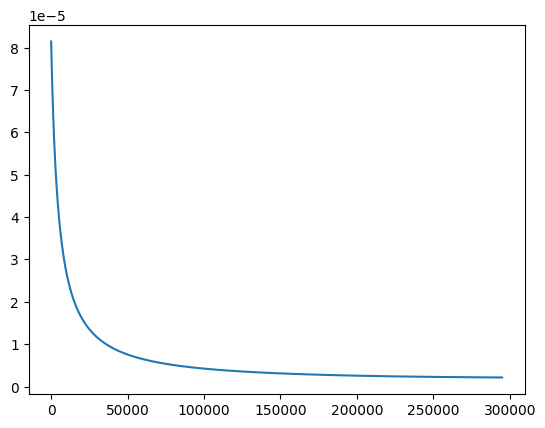

In [179]:
plt.plot(losses[5000:])